In [35]:
%pip install pandas numpy matplotlib seaborn scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Elena\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [36]:
# Импорт необходимых библиотек

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [52]:
# Загрузка данных
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)

print(df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [53]:
# Анализ данных
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


В каких столбцах есть NaN'ы?
Ответ: NaN'ы присутствуют в столбцах 'Age', 'Cabin' и 'Embarked'.

Ориентируясь на количество NaN'ов в столбцах, определите, какие строки "не жалко" выбросить, а какие лучше сохранить.
Ответ: cтолбец 'Age' имеет 177 пустых значений.Поскольку 'Age' может быть важным признаком для предсказания выживаемости на Титанике, поэтому выбрасывать все строки с пропущенными значениями в 'Age' может привести к потере значительной части данных.
Столбец 'Cabin' имеет только 204 непустых значения из 891. Это означает, что 687 значений пропущены.690 значений в 'Cabin' отсутствуют. Это очень большое количество пропусков. В таком случае, скорее всего, этот столбец лучше будет удалить, так как он содержит слишком много пропущенных данных

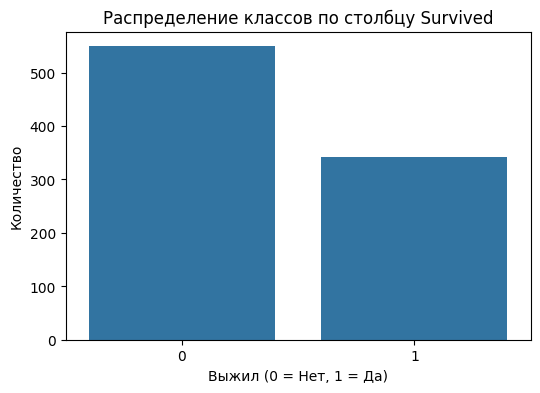

In [54]:
# Визуализация распределение классов по столбцу Survived
plt.figure(figsize=(6, 4))
sns.countplot(x='Survived', data=df)
plt.title('Распределение классов по столбцу Survived')
plt.xlabel('Выжил (0 = Нет, 1 = Да)')
plt.ylabel('Количество')
plt.show()

In [55]:
# Количество каждого класса в столбце 'Survived'
class_counts = df['Survived'].value_counts()
print("Количество объектов в каждом классе 'Survived':")
print(class_counts)

class_proportions = df['Survived'].value_counts(normalize=True)
print("\nПроцентное соотношение классов 'Survived':")
print(class_proportions)

survived_0_count = class_counts[0]
survived_1_count = class_counts[1]
total_passengers = len(df)

print(f"\nВыживших (1): {survived_1_count} ({survived_1_count / total_passengers:.2%})")
print(f"Невыживших (0): {survived_0_count} ({survived_0_count / total_passengers:.2%})")

Количество объектов в каждом классе 'Survived':
Survived
0    549
1    342
Name: count, dtype: int64

Процентное соотношение классов 'Survived':
Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

Выживших (1): 342 (38.38%)
Невыживших (0): 549 (61.62%)


Сбалансированы ли классы в нашем датасете?
Ответ: Нет, классы в столбце 'Survived' не сбалансированы. Судя по графику (и по процентному соотношению), количество невыживших (0) превышает количество выживших (1).

Столбцы с категориальными данными

In [56]:
categorical_columns = df.select_dtypes(include='object').columns.tolist()
categorical_columns.append('Pclass')
print(f"\nСтолбцы с категориальными данными: {categorical_columns}") 
# Ответ: большинство алгоритмов машинного обучения работают только с числовыми данными. Категориальные данные не могут быть напрямую поданы в такие модели, их необходимо преобразовать в числовой формат.


Столбцы с категориальными данными: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Pclass']


Требуется ли балансировка классов?
Ответ: балансировка классов, скорее всего, потребуется. Как мы выяснили ранее, классы в столбце Survived несбалансированы (невыживших значительно больше).

Какие столбцы нужно дропнуть?

Ответ: Cabin (содержит слишком много пропущенных значений), Name и Ticket (содержит уникальные значения, не несут информации для модели).

Какие данные нужно преобразовать к виду числовых?

Ответ: категориальные столбцы (Sex, Embarked, Pclass).

In [57]:
# Создаем новый датафрейм с нужными данными
columns_to_drop = ['Cabin', 'Name', 'Ticket', 'PassengerId'] # удаляем ненужные столбцы 

df = df.drop(columns=columns_to_drop)

# Выведем первые 5 строк нового датафрейма
print(df_cleaned.head())

   Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0         0       3    male  22.0      1      0   7.2500        S
1         1       1  female  38.0      1      0  71.2833        C
2         1       3  female  26.0      0      0   7.9250        S
3         1       1  female  35.0      1      0  53.1000        S
4         0       3    male  35.0      0      0   8.0500        S


In [58]:
# образец кодирования столбца 'Sex' с LabelEncoder
df['Sex'] = LabelEncoder().fit_transform(df['Sex'])  # 0 = female, 1 = male
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,S
1,1,1,0,38.0,1,0,71.2833,C
2,1,3,0,26.0,0,0,7.9250,S
3,1,1,0,35.0,1,0,53.1000,S
4,0,3,1,35.0,0,0,8.0500,S


In [59]:
# Кодирование 'Embarked' с get_dummies (One-Hot Encoding)
df = pd.get_dummies(df, columns=['Embarked'])  # one-hot encoding

df = pd.get_dummies(df, columns=['Pclass'], prefix='Pclass', dtype=int)


print("Окончательный обработанный датафрейм:")
print(df.head())

Окончательный обработанный датафрейм:
   Survived  Sex   Age  SibSp  Parch     Fare  Embarked_C  Embarked_Q  \
0         0    1  22.0      1      0   7.2500       False       False   
1         1    0  38.0      1      0  71.2833        True       False   
2         1    0  26.0      0      0   7.9250       False       False   
3         1    0  35.0      1      0  53.1000       False       False   
4         0    1  35.0      0      0   8.0500       False       False   

   Embarked_S  Pclass_1  Pclass_2  Pclass_3  
0        True         0         0         1  
1       False         1         0         0  
2        True         0         0         1  
3        True         1         0         0  
4        True         0         0         1  


Изучите документацию и найдите дополнительные материалы, ответьте на вопрос: чем LabelEncoder отличается от get_dummies и когда какой метод лучше использовать?
Ответ: LabelEncoder преобразует категориальные метки в числа и создает один столбец с этими числовыми значениями. One-hot-encoding преобразует каждую категориальную метку в новый бинарный столбец, каждый столбец получает название от значение: "Columns in the output are each named after a value". Get_dummies не создает искусственный порядок, каждая категория является независимой (LabelEncoding создает искусственный порядок). 

LabelEncoder лучше использовать в задачах классификации, как уже была представлена классификация Survived в Титанике (0 или 1). Для признаков, которые имеют порядок 0<1<2 и в случаях, когжа признаков слишком много, т.к. One-Hot Encoding создат много столбцов, что повлияет на производительность. 

Итог:
Выбор между LabelEncoder и get_dummies зависит от типа категориального признака (порядковый или номинальный) и типа используемой модели машинного обучения. Для номинальных признаков и моделей, чувствительных к порядку, get_dummies является более безопасным выбором. LabelEncoder лучше использовать для целевой переменной или для порядковых признаков.

In [60]:
# Заполнение пропусков
# заполняем пропуски в столбце Age
imputer = SimpleImputer(strategy="mean")
df['Age'] = imputer.fit_transform(df[['Age']])

In [ ]:
Изучите документацию sklearn и ответьте на вопросы: какие стратегии доступы для работы с методом SimpleImputer? Чем они отличаются? Какие стратегии подойдут для работы с категориальными данными?

Ответ:согласно документации, доступны следующие стратегии:"mean", "median","most_frequent","constant". Каждая стратегия определяет, каким образом будут заполняться NaNы в столбцах.

strategy="mean" Заменяет пропущенные значения в каждом столбце на среднее арифметическое значение всех непустых значений в этом столбце.
strategy="median" Заменяет пропущенные значения в каждом столбце на медиану всех непустых значений в этом столбце.
strategy="most_frequent" Заменяет пропущенные значения в каждом столбце на наиболее часто встречающееся значение всех непустых значений в этом столбце.
strategy="constant" Заменяет пропущенные значения в каждом столбце на заданное пользователем постоянное значение. Это значение указывается в параметре fill_value.

strategy="most_frequent": наиболее распространенная и  стратегия для заполнения пропусков в категориальных столбцах. Она позволяет сохранить существующие категории и заполнить пропуски наиболее типичным значением.
strategy="constant": стратегия также отлично подходит для категориальных данных, чтобы заполнить пропуски специальной строкой, например, "Другое".

In [61]:
# Добавим фичу Family size = SibSp + Parch + 1 (единица обозначает самого пассажира)
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

# Фича Alone для тех, кто путешествует один
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

df.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,FamilySize,IsAlone
0,0,1,22.0,1,0,7.2500,False,False,True,0,0,1,2,0
1,1,0,38.0,1,0,71.2833,True,False,False,1,0,0,2,0
2,1,0,26.0,0,0,7.9250,False,False,True,0,0,1,1,1
3,1,0,35.0,1,0,53.1000,False,False,True,1,0,0,2,0
4,0,1,35.0,0,0,8.0500,False,False,True,0,0,1,1,1


In [62]:
# Добавление AgeGroup

bins = [0, 12, 18, 70, np.inf] # Дети (0-12), Подростки (13-18), Взрослые (19-60), Пожилые (71+)
labels = ['Child', 'Teenager', 'Adult', 'Senior']

df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True)

print("\nУникальные значения в 'AgeGroup':")
print(df['AgeGroup'].value_counts())
print(df.head())


Уникальные значения в 'AgeGroup':
AgeGroup
Adult       747
Teenager     70
Child        69
Senior        5
Name: count, dtype: int64
   Survived  Sex   Age  SibSp  Parch     Fare  Embarked_C  Embarked_Q  \
0         0    1  22.0      1      0   7.2500       False       False   
1         1    0  38.0      1      0  71.2833        True       False   
2         1    0  26.0      0      0   7.9250       False       False   
3         1    0  35.0      1      0  53.1000       False       False   
4         0    1  35.0      0      0   8.0500       False       False   

   Embarked_S  Pclass_1  Pclass_2  Pclass_3  FamilySize  IsAlone AgeGroup  
0        True         0         0         1           2        0    Adult  
1       False         1         0         0           2        0    Adult  
2        True         0         0         1           1        1    Adult  
3        True         1         0         0           2        0    Adult  
4        True         0         0         1    

In [ ]:
# Преобразование AgeGroup в числовые значения с помощью get_dummies
df = pd.get_dummies(df, columns=['AgeGroup'], prefix='AgeGroup', dtype=int)

In [66]:
# Обучени 
X = df.drop(columns=['Survived']) # данные = все столбцы кроме метки Survived
y = df['Survived'] # метки = только столбец Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

print("Размер обучающей выборки X_train:", X_train.shape)
print("Размер тестовой выборки X_test:", X_test.shape)
print("Размер обучающей выборки y_train:", y_train.shape)
print("Размер тестовой выборки y_test:", y_test.shape)

print("\nРаспределение классов в y:")
print(y.value_counts(normalize=True))
print("\nРаспределение классов в y_train:")
print(y_train.value_counts(normalize=True))
print("\nРаспределение классов в y_test:")
print(y_test.value_counts(normalize=True))

Размер обучающей выборки X_train: (712, 17)
Размер тестовой выборки X_test: (179, 17)
Размер обучающей выборки y_train: (712,)
Размер тестовой выборки y_test: (179,)

Распределение классов в y:
Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

Распределение классов в y_train:
Survived
0    0.616573
1    0.383427
Name: proportion, dtype: float64

Распределение классов в y_test:
Survived
0    0.614525
1    0.385475
Name: proportion, dtype: float64


Какую роль играет StandardScaler в работе с логистической регрессией?
Ответ: StandardScaler перед обучением логистической регрессии ускоряет процесс обучения, повышения стабильности модели, особенно при использовании регуляризации, улучшения интерпретируемости весов/коэффициентов модели.

In [67]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Логистическая регрессия - это алгоритм классификации, который предсказывает вероятность того, что объект принадлежит к определенному классу. Она использует линейную комбинацию входных признаков, а затем пропускает результат через сигмоидную функцию, чтобы преобразовать его в вероятность от 0 до 1. Если эта вероятность превышает заданный порог, объект классифицируется как принадлежащий к одному классу, в противном случае - к другому.

In [68]:
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

# предсказания
y_pred_log = log_reg.predict(X_test_scaled)

# вывод репорта
print("Logistic Regression Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

Logistic Regression Performance:
Accuracy: 0.8268156424581006
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       110
           1       0.83      0.70      0.76        69

    accuracy                           0.83       179
   macro avg       0.83      0.80      0.81       179
weighted avg       0.83      0.83      0.82       179



Что значит Gaussian в названии метода GaussianNB? Почему для этого метода не нужен StandardScaler?
Gaussian значит, что фичи имеют нормальное (Гауссово) распределение. StandardScaler не нужен, потому что GaussianNB внутренне сам работает с предположением о нормальном распределении данных. Он вычисляет среднее и стандартное отклонение для каждого признака. 

In [69]:
nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred_nb = nb.predict(X_test)

print("Naïve Bayes Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

Naïve Bayes Performance:
Accuracy: 0.7430167597765364
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       110
           1       0.66      0.68      0.67        69

    accuracy                           0.74       179
   macro avg       0.73      0.73      0.73       179
weighted avg       0.74      0.74      0.74       179



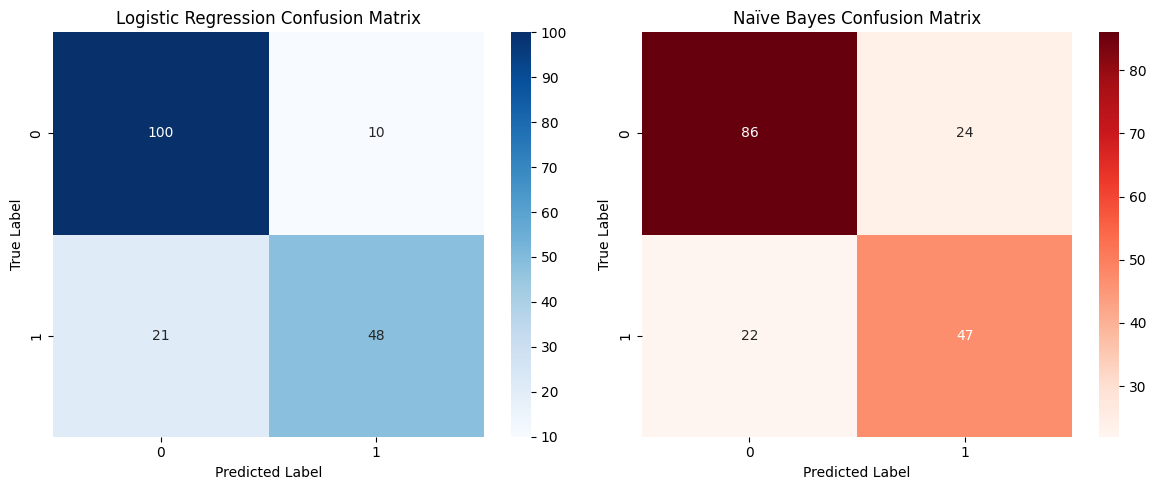

: 

In [ ]:
conf_matrix_log = confusion_matrix(y_test, y_pred_log)
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(conf_matrix_log, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Logistic Regression Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

sns.heatmap(conf_matrix_nb, annot=True, fmt="d", cmap="Reds", ax=axes[1])
axes[1].set_title("Naïve Bayes Confusion Matrix")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout() # Для улучшения расположения графиков
plt.show()

In [ ]:
import featuretools as ft

ModuleNotFoundError: No module named 'pkg_resources'

: 